In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/cards'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [56]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
#from tensorflow.keras.callbacks import Callback, EarlyStopping
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, Callback

In [57]:
from pathlib import Path
from tqdm import tqdm
import os

file_names = []
labels = []

for file in tqdm(sorted(Path('cards').glob('**/*.jpg'))):
    label = str(file.parent.name)  
    labels.append(label)
    file_names.append(str(file)) 
    

data_df = pd.DataFrame({"images": file_names, "labels": labels})

data = data_df.sample(frac=1).reset_index(drop=True)
data = data[data['labels'] != 'joker']
data['labels'] = data['labels'].apply(lambda x: x.split(" ")[2])
print(data.head)
a = "two of spades"
print(a.split(" "))
    


100%|██████████| 8154/8154 [00:00<00:00, 197550.60it/s]

<bound method NDFrame.head of                                      images    labels
0       cards\train\seven of spades\095.jpg    spades
1         cards\train\four of clubs\109.jpg     clubs
2       cards\train\queen of spades\093.jpg    spades
3      cards\train\jack of diamonds\082.jpg  diamonds
4       cards\train\seven of hearts\136.jpg    hearts
...                                     ...       ...
8148     cards\train\three of clubs\069.jpg     clubs
8149    cards\train\seven of hearts\056.jpg    hearts
8150  cards\train\three of diamonds\134.jpg  diamonds
8152     cards\train\queen of clubs\150.jpg     clubs
8153     cards\train\nine of spades\132.jpg    spades

[8029 rows x 2 columns]>
['two', 'of', 'spades']


In [58]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)
print(train_df.size)
print(test_df.size)

12846
3212


In [59]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class_count_train = train_df['labels'].value_counts().to_dict()
class_count_test = test_df['labels'].value_counts().to_dict()
def setup(preprocess=False):
    if preprocess:
        horizantal_flip = False
        width_shift_range=0
        shear_range=0
        batch_size = 32
        target_size = (224,224)

        augmented_train = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2)

        augmented_test = ImageDataGenerator(
        preprocessing_function=preprocess_input)
    else:
        horizantal_flip = True
        width_shift_range=0.2
        shear_range=0.15
        target_size = (224,224)
        batch_size = 32
        
        augmented_train = ImageDataGenerator(
            #rotation_range=10,
            #width_shift_range=0.1,
            #height_shift_range=0.1,
            #shear_range=0,
            #horizontal_flip=True,
            #zoom_range=0.225,
            rescale=1/255,
            validation_split=0.2)

        augmented_test = ImageDataGenerator(
            #rotation_range=10,
            #width_shift_range=0.1,
            #height_shift_range=0.1,
            #shear_range=0,
            #horizontal_flip=True,
            #zoom_range=0.225,
            rescale=1/255)
    
    train = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='labels',
    target_size=target_size,#check here
    subset="training",
    batch_size=batch_size,
    #batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    horizontal_flip=horizantal_flip,
    fill_mode="nearest",
    #rotation_range=30,
    #zoom_range=0.15,
    width_shift_range=width_shift_range,
    #height_shift_range=0.2,
    shear_range=shear_range,
)
    val = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='labels',
    target_size=target_size,#check here
    subset="validation",
    batch_size=batch_size,
    #batch_size=16,
    class_mode='categorical',
    shuffle=False,
    seed=0,
    horizontal_flip=horizantal_flip,
    fill_mode="nearest",
    #rotation_range=30,
    #zoom_range=0.15,
    width_shift_range=width_shift_range,
    #height_shift_range=0.2,
    shear_range=shear_range,
    #shuffle=True
)

    test = augmented_test.flow_from_dataframe(
    dataframe=test_df,
    shuffle=False,
    x_col='images',
    y_col='labels',
    target_size=target_size,#check here
    batch_size=batch_size,
    #batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    seed=0,
    #verbose=0,
    #chelck
)
    
    return train, val, test
train, val, test = setup()
train_1, val_1, test_1 = setup(preprocess=True)

Found 5139 validated image filenames belonging to 4 classes.
Found 1284 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.
Found 5139 validated image filenames belonging to 4 classes.
Found 1284 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [60]:
#print(max(train.classes))
class_count = max(train.classes) + 1

In [61]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
#from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
#from tensorflow.keras.applications import MobileNetV2

model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.2),
    
    Conv2D(64, (3, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

In [62]:
"""
from sklearn.utils.class_weight import compute_class_weight

classes = list(class_count_train.keys())
print(class_count_train)
y = np.concatenate([[i] * class_count_train[klass] for i, klass in enumerate(classes)])
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = {i: weight for i, weight in enumerate(weights)}
print(weight_dict)"""

"\nfrom sklearn.utils.class_weight import compute_class_weight\n\nclasses = list(class_count_train.keys())\nprint(class_count_train)\ny = np.concatenate([[i] * class_count_train[klass] for i, klass in enumerate(classes)])\nweights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)\nweight_dict = {i: weight for i, weight in enumerate(weights)}\nprint(weight_dict)"

In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),#todo, consider changing logits
              metrics=['accuracy'])
#callback commented out
callback = [EarlyStopping(monitor='val_accuracy', patience = 0.8, restore_best_weights=True)]#tweak patience
callbacks = [
        #ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
        #CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
    ] 

history = model.fit(train, epochs=10, 
validation_data=val, callbacks=callbacks)

Epoch 1/10
161/161 [==============================] - 234s 1s/step - loss: 1.0334 - accuracy: 0.5295 - val_loss: 0.6707 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 2/10
161/161 [==============================] - 270s 2s/step - loss: 0.6276 - accuracy: 0.7426 - val_loss: 0.5095 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 3/10
161/161 [==============================] - 291s 2s/step - loss: 0.3377 - accuracy: 0.8753 - val_loss: 0.3267 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 4/10
161/161 [==============================] - 261s 2s/step - loss: 0.1882 - accuracy: 0.9352 - val_loss: 0.3068 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 5/10
161/161 [==============================] - 295s 2s/step - loss: 0.1377 - accuracy: 0.9570 - val_loss: 0.3014 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 6/10
161/161 [==============================] - 244s 2s/step - loss: 0.0963 - accuracy: 0.9669 - val_loss: 0.2875 - val_accuracy: 0.9198 - lr: 0.0010
Epoch 7/10
161/161 [==============================] - 242s 2s/st

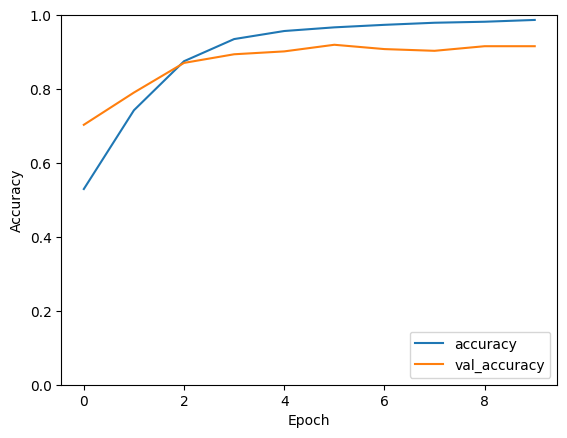

In [64]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


In [65]:
from sklearn.metrics import classification_report

def report(this_model, name):
    #test.reset()
    if name == "Liam":
        true_labels = test_df.labels
        print(true_labels)
        predictions = this_model.predict(test)
    else:
        true_labels = test_df.labels
        predictions = this_model.predict(test_1)
    predictions = np.argmax(predictions, axis=1)
    labels = (train.class_indices)
    labels = dict((i,j) for j,i in labels.items())
    pred_classes = [labels[i] for i in predictions]
    report = classification_report(true_labels, 
                                   pred_classes)
    return report

In [69]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
#pretrained model 
mobile_model = MobileNetV2(input_shape=(224,224, 3),
                include_top=False,
                weights='imagenet',
                pooling='avg')
mobile_model.trainable = False
inputs = mobile_model.input
x = Dense(64, activation='relu')(mobile_model.output)
x = Dense(64, activation='relu')(x)
outputs = Dense(class_count, activation='softmax')(x)
mobile = Model(inputs=inputs, outputs=outputs)
mobile.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
"""
callback  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
                              """
callbacks = [
        #ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
        #CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
    ] 
history = mobile.fit(train_1, validation_data=val_1, epochs=12,callbacks=callbacks,verbose=1);

Epoch 1/12
161/161 [==============================] - 163s 994ms/step - loss: 0.6792 - accuracy: 0.7143 - val_loss: 0.5113 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 2/12
161/161 [==============================] - 172s 1s/step - loss: 0.4446 - accuracy: 0.8188 - val_loss: 0.4544 - val_accuracy: 0.8115 - lr: 0.0010
Epoch 3/12
161/161 [==============================] - 184s 1s/step - loss: 0.3539 - accuracy: 0.8589 - val_loss: 0.4363 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 4/12
161/161 [==============================] - 181s 1s/step - loss: 0.2859 - accuracy: 0.8910 - val_loss: 0.4532 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 5/12
161/161 [==============================] - 193s 1s/step - loss: 0.2237 - accuracy: 0.9171 - val_loss: 0.4555 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 6/12
161/161 [==============================] - 180s 1s/step - loss: 0.1640 - accuracy: 0.9408 - val_loss: 0.4962 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 7/12
161/161 [==============================] - 169s 1s

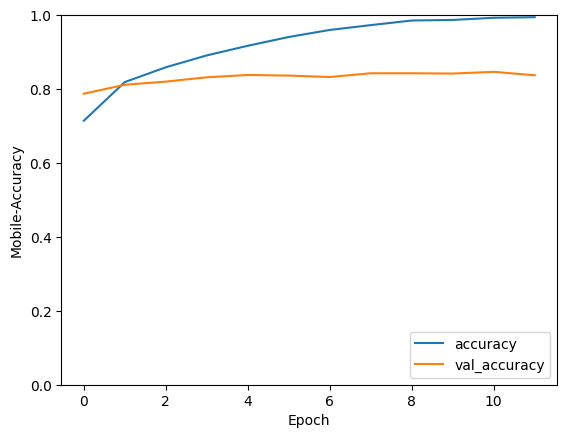

In [71]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mobile-Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [67]:
report(model, "Liam")

3014       clubs
424     diamonds
105       spades
3258       clubs
1709    diamonds
          ...   
1459       clubs
7752    diamonds
5079      hearts
8083      hearts
5325    diamonds
Name: labels, Length: 1606, dtype: object
51/51 [==============================] - 24s 472ms/step


'              precision    recall  f1-score   support\n\n       clubs       0.93      0.93      0.93       400\n    diamonds       0.93      0.89      0.91       399\n      hearts       0.93      0.93      0.93       382\n      spades       0.89      0.92      0.90       425\n\n    accuracy                           0.92      1606\n   macro avg       0.92      0.92      0.92      1606\nweighted avg       0.92      0.92      0.92      1606\n'

In [70]:
print("_______________Liams Model__________________")
print(report(model, "Liam"))
print("_______________Mobile Net___________________")
print(report(mobile, "Mobile"))

_______________Liams Model__________________
3014       clubs
424     diamonds
105       spades
3258       clubs
1709    diamonds
          ...   
1459       clubs
7752    diamonds
5079      hearts
8083      hearts
5325    diamonds
Name: labels, Length: 1606, dtype: object
51/51 [==============================] - 27s 534ms/step
              precision    recall  f1-score   support

       clubs       0.93      0.93      0.93       400
    diamonds       0.93      0.89      0.91       399
      hearts       0.93      0.93      0.93       382
      spades       0.89      0.92      0.90       425

    accuracy                           0.92      1606
   macro avg       0.92      0.92      0.92      1606
weighted avg       0.92      0.92      0.92      1606

_______________Mobile Net___________________
51/51 [==============================] - 56s 1s/step
              precision    recall  f1-score   support

       clubs       0.84      0.85      0.85       400
    diamonds       0.87     